In [1]:
import warnings
warnings.filterwarnings("ignore")

# 1º: Create the Molecule and Hamiltonian

In the code cells below, we create the molecular geometry of H2 with the radial distance of 1,401 a.u. with the optimal internuclear distance of Szabo and Ostlund. We will use the STO-3G minimal basis set by importing the parameters of the basis set exchange functions. Pennylane allows us to construct the Hamiltonian from the second quantization with the Jordan-Wigner transformation.

In [2]:
from qiskit_ibm_runtime.fake_provider import FakeAthensV2
from pennylane_qiskit import qiskit_session
from skquant.opt import minimize

from pennylane import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml

symbols = ["H", "H"]
coordinates = np.array([[0.0, 0.0, 0], [0.0, 0.0, 1.401]], requires_grad = False)
molecule = qml.qchem.Molecule(symbols, coordinates, basis_name='STO-3G', load_data=True, unit='bohr')
H, qubits = qml.qchem.molecular_hamiltonian(molecule)

print("Number of qubits = ", qubits)
print("The Hamiltonian is ", H)

Number of qubits =  4
The Hamiltonian is  -0.09883485860187924 * I([0, 1, 2, 3]) + 0.17120123803197834 * Z(0) + 0.17120123803197845 * Z(1) + 0.16862327620358059 * (Z(0) @ Z(1)) + -0.22279639115527738 * Z(2) + 0.12054612718324412 * (Z(0) @ Z(2)) + 0.16586801098505832 * (Z(1) @ Z(2)) + 0.045321883801814206 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.045321883801814206 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.045321883801814206 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.045321883801814206 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.22279639115527738 * Z(3) + 0.16586801098505832 * (Z(0) @ Z(3)) + 0.12054612718324412 * (Z(1) @ Z(3)) + 0.17434948668373768 * (Z(2) @ Z(3))


# 2º: Configure the Simulator

Our goal is to simulate UCCSD with the ground state and the doubly excited state by means of Givens rotations, provided by Pennylane. For comparison purposes, we will use two simulators: a noisy one and a noiseless one. Our purpose is to simulate the ground state of the H2 molecule using two types of devices.

In [3]:
try:
    fake_athensv2 = FakeAthensV2()
    num_qubits = fake_athensv2.num_qubits
    dev1 = qml.device("qiskit.aer", wires=qubits, backend='statevector_simulator',shots=None)
    dev2 = qml.device("qiskit.remote", wires=num_qubits, backend=fake_athensv2,shots=8000)

except Exception as exc:
    print("failed to connect to backend. Exception thrown")
    print(exc)

In [4]:
electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

[1 1 0 0]


In [5]:
@qml.qnode(dev1)
def circuit1(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0, 1, 2, 3])
    return qml.expval(H)

@qml.qnode(dev2)
def circuit2(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0, 1, 2, 3])
    return qml.expval(H)

In [6]:
def cost_fn1(param):
    return float(circuit1(param, wires=range(qubits)))

def cost_fn2(param):
    return float(circuit2(param, wires=range(qubits)))

# 3º: Configure the optimizer and run the circuit

In the code cells below, we configure the ImFil optimizer, a derivative-free optimizer that is great for noisy environments. It is important to note that although the optimizer is designed to work well in noisy environments, this does not make it noise-proof and fully capable of finding the solution in noisy environments.

Again, our main goal is to run two simulators: a noisy one and a noiseless one. In this scenario, we are using the same classic optimizer: Implicit Filtering (ImFil).

We configure ImFil with 250 steps (converging in less than 30 steps), starting from parameter 0 (Hartree-Fock ground state) and exploring the limited region from -1.0 to 1.0. We also pass the parameter angles that will be optimized. We run both circuits until reaching convergence (minimum).

In [7]:
theta0 = np.array([0.0])
budget = 250
bounds = np.array([[-1.0, 1.0]], dtype=float)

In [8]:
result1, history1 = minimize(cost_fn1, theta0, bounds, budget, method='imfil')

In [9]:
result2, history2 = minimize(cost_fn2, theta0, bounds, budget, method='imfil')

In [10]:
print("Noise Free Simulator Results:")
print(f"Optimal Energy Found: {result1.optval} ha")
print(f"Optimal Parameter Found: {result1.optpar} rad")
print(f"Steps Until Convergence: {len(history1)}")

Noise Free Simulator Results:
Optimal Energy Found: -1.1372700020855604 ha
Optimal Parameter Found: 0.22714648556840444 rad
Steps Until Convergence: 29


In [11]:
print("Noisy Simulator Results:")
print(f"Optimal Energy Found: {result2.optval} ha")
print(f"Optimal Parameter Found: {result2.optpar} rad")
print(f"Steps Until Convergence: {len(history2)}")

Noisy Simulator Results:
Optimal Energy Found: -0.5160636273132063 ha
Optimal Parameter Found: 0.25 rad
Steps Until Convergence: 29


# 4º: Collect and Analyze Results

It is interesting to note that, in both scenarios, the optimizer converged with a sequence of steps smaller than L-BFGS. This is most likely due to the fact that we already know the ideal parameter for the L-BFGS calculation, our initial guess, and our constraints for the search limit (-1, 1). The slow convergence in L-BFGS can also be explained by the learning rate we configured.

It is interesting to note that ImFil, in the noise-free version, seeks to explore the points of the initial limit, increasingly reducing the search space of the parameters as it explores regions that lead to higher and lower energy values.

Unfortunately, even though it was built to withstand noise, the classic ImFil optimizer fails to find the global minimum, becoming subject to noise and eventually getting stuck in a local minimum.

In [12]:
hf_energy = -1.1167
fci_energy = -1.13726

energies1 = [e[0] for e in history1]
thetas1 = [t[1] for t in history1]

energies2 = [e[0] for e in history2]
thetas2 =[t[1] for t in history2] 

steps1 = list(range(len(energies1))) 
steps2 = list(range(len(energies2)))

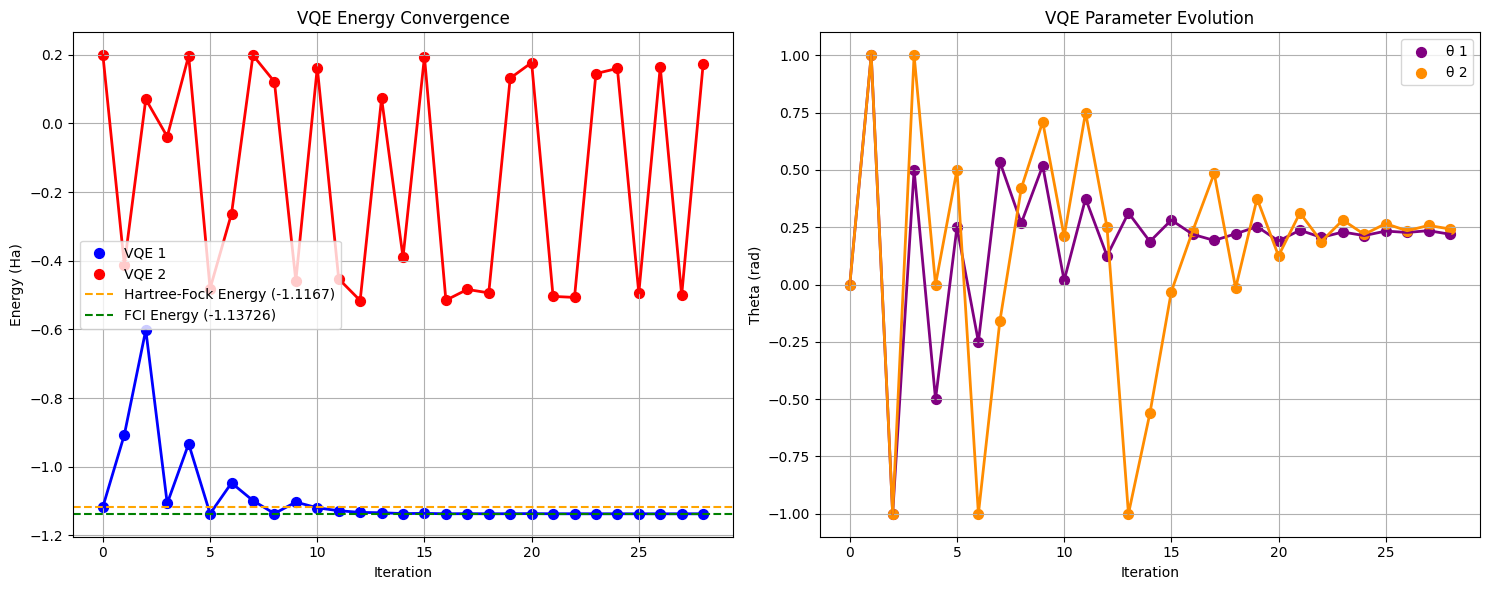

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].scatter(steps1, energies1, label='VQE 1', color='blue', s=50)
axs[0].plot(steps1, energies1, color='blue', linewidth=2)
axs[0].scatter(steps2, energies2, label='VQE 2', color='red', s=50)
axs[0].plot(steps2, energies2, color='red', linewidth=2)

axs[0].axhline(hf_energy, color='orange', linestyle='--', label=f'Hartree-Fock Energy ({hf_energy})')
axs[0].axhline(fci_energy, color='green', linestyle='--', label=f'FCI Energy ({fci_energy})')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Energy (Ha)')
axs[0].set_title('VQE Energy Convergence')
axs[0].legend()
axs[0].grid(True)


axs[1].scatter(steps1, thetas1, label='θ 1', color='purple', s=50)
axs[1].plot(steps1, thetas1, color='purple', linewidth=2)
axs[1].scatter(steps2, thetas2, label='θ 2', color='darkorange', s=50)
axs[1].plot(steps2, thetas2, color='darkorange', linewidth=2)

axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Theta (rad)')
axs[1].set_title('VQE Parameter Evolution')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()